# **この Notebook は、[インドの話をゆっくりと: インド進出日系企業リスト 2019版が公表されました](https://ggcs.io)の手順詳細版です。**

- Website: ごたごた気流調査所  https://ggcs.io
- GitHub : Gota Gota Current Survey  https://github.com/ggcurrs
- Version 1.0.0
- Date   : 2020-09-07
- Updated: None

この Python Script は、**在インド日本国大使館**及び**ジェトロ**が定期的に更新し、大使館がウェブページで公開している[インド進出日系企業リスト](https://www.in.emb-japan.go.jp/Japanese/Japanese_companies_2019.html)をダウンロードし、リストを CSV に整理するものです。

貴重なデータの取りまとめ、公開を行っている在インド日本国大使館及びジェトロの皆様にこの場を借りて感謝申し上げます。

# 作業準備
- 前提
  - ***tabula-py が Google Drive の ~/My Drive/Colab Notebooks/my-modules にインストールされていること。***
  - もし上記の前提が満たされていないようでしたら、[Google Colab: PDF to CSV 変換器を Colab に設置 \[第一話 立志篇\] – これでコピペ作業 から開放！](https://ggcs.io/2020/08/05/google-colab-pdf-export-01/)を参照の上、tabula-py をインストールしておいてください。
  - [オリジナルの PDF](https://www.in.emb-japan.go.jp/Japanese/Japanese_companies_2019.html) は適宜アップデートされますので、その場合以下のスクリプトがうまく走らなくなる可能性もありますが、その場合でもスクリプトにそれほど大きな手直しをしなくても対応できると思います（祈り 🙏）。

In [ ]:
# Google Drive のマウント。
from google.colab import drive
drive.mount('/content/drive')

# Modules の import.
import os
import sys
# PATH を通す（Python に modules の場所を教える）
MODULE_PATH = '/content/drive/My Drive/Colab Notebooks/my-modules'
sys.path.append(MODULE_PATH)
import tabula  # Module の場所を教えたので、import.
import pandas as pd  # 念のため明示的に import しておく。
import requests
from natsort import natsorted

# ディレクトリ構造を定義する。
PROJECT_ROOT_PATH = '.'
DATA_PATH   = os.path.join(PROJECT_ROOT_PATH, 'data')
OUTPUT_PATH = os.path.join(PROJECT_ROOT_PATH, 'output')

if not os.path.isdir(DATA_PATH):
  os.mkdir(DATA_PATH)

if not os.path.isdir(OUTPUT_PATH):
  os.mkdir(OUTPUT_PATH)

print('準備完了 🍻')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
準備完了 🍻


- Google Colab 上で作業ディレクトリを変更せずにそのまま作業を行った場合、関連ファイルは下図左の場所に保存されます。
- ここに置いたファイルは Runtime が更新されると消えてしまうので、必要なファイルはその前に download しておく必要があります。


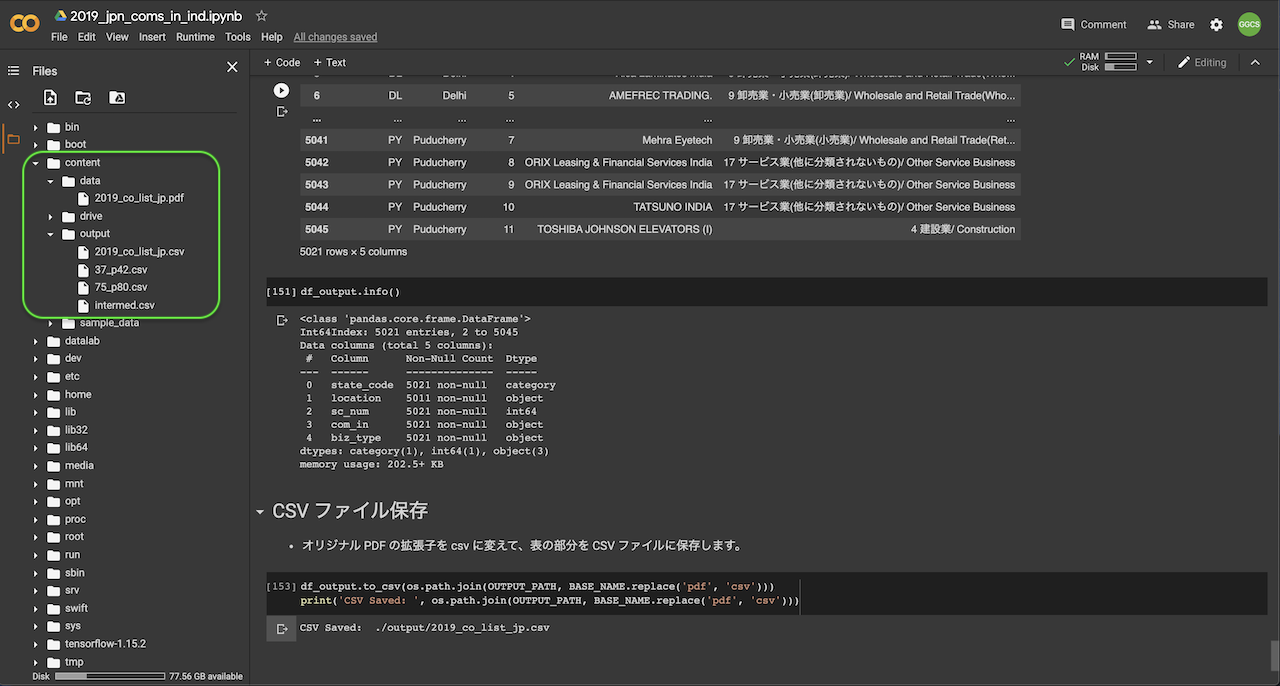

# PDF ファイルの読み込み (Load a PDF File)

In [ ]:
%%time
# 2020-08-31に 2019年版が公表されたました。
# DATA_PATH に 2019年版の PDF が用意されていない場合はダウンロードします。
# Download the Source File
SOURCE_URL   = 'https://www.in.emb-japan.go.jp/PDF/2019_co_list_jp.pdf'
BASE_NAME    = os.path.basename(SOURCE_URL)
ORIGINAL_PDF = os.path.join(DATA_PATH, BASE_NAME)

# Check if the file already exists.
if not os.path.isfile(os.path.join(DATA_PATH, BASE_NAME)):
  print('Start downloading')
  try:
    with open(ORIGINAL_PDF, 'wb') as f:
      f.write(requests.get(SOURCE_URL).content)
      print('DONE!')
  except Exception as exc:
    print(f'Error: {exc}')
else:
  print('The PDF already exists:\n', ORIGINAL_PDF, '\n')

In [ ]:
%%time
# PDF ファイルの読み込み（30 秒程度掛かります）
# WARNING がイッパイ出ますが、無視して差し支えありません。
df_list = tabula.read_pdf(ORIGINAL_PDF, pages='5-114')

print('DONE!')

# Data Cleansing

## **現状確認**

### DataFrame Shape の確認
- tabula で読み込んだ PDF ファイルには、PDF のページで p.5 から p.114 までの合計 110 pages 分の Pandas DataFrame（以下「DF」） がリストの形で格納されています。
- ここで、それぞれの DF の shape （row \* columns）を確認してみます（TABLE 1）。
- 形はバッチリ揃っている（037/p.042, 075/p.080 と 109/p.114 はちょっと怪しそうですが...）。

In [ ]:
# TABLE 1: Shape of DFs
for i, each_df in enumerate(df_list):
  if i % 5 == 0:  # 5列ごとに改行
    print()
  print(str(i).zfill(3)+'/p.'+str(i+5).zfill(3), each_df.shape, ' ', end='')


### Column names の確認
- 次のスクリプトを走らせて 110 個の DF の 表頭（Column names. Microsoft Word でいうところの「タイトル行」）を確認すると以下のことがわかります（TABLE 2）。
1. Column name に全角文字やスペース、改行文字（\r）などが含まれている。作業の都合から言うと、これを放置しておくとあとあと悩みのタネになる。
2. index = 37(p.42), 75(p.80) の表頭が他と異なる。これは後で DF を 1 個にまとめる（concatenate）ときに悲劇を招く原因となる（オリジナル PDF の column names は揃っていたのだが tabula 読込 / parse 時に乱れてしまった）。


In [ ]:
# TABLE 2: Column names of the DFs
# オリジナルの Column names 確認
for i, each_df in enumerate(df_list):
  print('DF_No='+str(i)+'('+'p.'+str(i+5)+')', each_df.columns)

# DF_No=37(p.42), 75(p.80) の 表頭が他と異なる（'拠点地名 番号', 'Unnamed: 0'）ことがわかる。

In [ ]:
# 例としてDF_No=37(p.42)を見るとこんな感じ。手作業で直した方が早そう。
## '拠点地名'と'番号'の columns がくっついて一つになっている。
## 'Unnamed: 0' という予定外の column ができている。
df_list[37].info()

## Column Names 等の修正
- PC 上での手作業:
  - '拠点地名 番号' の分離は、text editor で Regex: r'(\w+) (\d+)' -> r'\1,\2' とやれば大体OK。
  - 上記の変換の後、'Unnamed: 0' の column は適当な CSV ソフトで開いて drop しておきます。

In [ ]:
# index = 37, 75 の DF を CSV に落として text editor 上で手作業で修正。
df_list[37].to_csv(os.path.join(OUTPUT_PATH, '37_p42.csv'), index=False)
df_list[75].to_csv(os.path.join(OUTPUT_PATH, '75_p80.csv'), index=False)

print('DONE!')

DONE!


### 手作業で修正済みの DF

In [ ]:
df_37_p42_corr = pd.DataFrame(
  [
    ['AS', 'Mangaldoi', 46,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Mirza', 47,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Moran', 48,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Nagaon', 49,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Naharkatia', 50,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Naharlagun', 51,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Nalbari', 52,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'North Lakshmipur', 53,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Pathasala', 54,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Shillong', 55,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Sibsagar', 56,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Silchar', 57,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Silchar', 58,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AS', 'Tinsukhia', 59,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AR', 'Eluru', 1,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AR', 'Itanagar', 2, 'TATSUNO INDIA',
    '17 サービス業(他に分類されないもの)/ Other Service Business'],
    ['AR', 'Mancherial', 3,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AR', 'Nizamabad', 4,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['AR', 'c', 5, 'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['ML', 'West Garo Hills', 1, 'TATSUNO INDIA',
    '17 サービス業(他に分類されないもの)/ Other Service Business'],
    ['MZ', 'Aizawl', 1,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['SK', 'Gangtok', 1, 'Cholamandalam MS General Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['SK', 'Gangtok', 2,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['TR', 'Agartala', 1, 'Cholamandalam MS General Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['TR', 'Agartala', 2, 'Max Life Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['TR', 'Agartala', 3, 'TATSUNO INDIA',
    '17 サービス業(他に分類されないもの)/ Other Service Business'],
    ['NL', 'Dimapur', 1, 'TATSUNO INDIA',
    '17 サービス業(他に分類されないもの)/ Other Service Business'],
    ['WB', 'Alipurduar', 1,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Arambagh', 2,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Asansol', 3, 'Air Water India',
    '5 製造業(化学工業)/ Manufacturing(Chemical Industry)'],
    ['WB', 'Asansol', 4, 'Max Life Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Asansol', 5, 'Universal Sompo General Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Bagdogra', 6,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Barasat', 7, 'IFFCO Tokio General Insurance .',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Barasat', 8,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Barddhaman', 9, 'Max Life Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Baruipur', 10,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['WB', 'Basirhat', 11,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry']
  ],

  columns=['state_code', 'location', 'sc_num', 'com_in', 'biz_type']
)

print('df_37_p42_corr is READY!')

In [ ]:
df_75_p80_corr = pd.DataFrame(
  [
    ['CG', 'Chandigarh', 11,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Durg', 12, 'Edelweiss Tokio Life Insurance Company',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Durg', 13, 'Max Life Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Durg', 14, 'TATSUNO INDIA',
    '17 サービス業(他に分類されないもの)/ Other Service Business'],
    ['CG', 'Jagadalpur', 15,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Mandigobind Garh', 16,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Raigarh', 17, 'Cholamandalam MS General Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Raipur', 18, 'Bridgestone India',
    '5 製造業(ゴム製品,なめし革・同製品・毛皮,窯業・土石製品製造業)/Manufacturing(Rubber Product, Tannage, Fur, Soil & Stone Product)'],
    ['CG', 'Raipur', 19, 'Edelweiss Tokio Life Insurance Company',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Raipur', 20, 'KCT Trading',
    '9 卸売業・小売業(卸売業)/ Wholesale and Retail Trade(Wholesale)'],
    ['CG', 'Raipur', 21, 'Maruti Suzuki India',
    '5 製造業(輸送用機械器具製造業)/ Manufacturing(Transport Equipment Manufacturing)'],
    ['CG', 'Raipur', 22, 'Max Life Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Raipur', 23, 'Nippon Paint (India)',
    '5 製造業(その他の製造業)/  Manufacturing(Others)'],
    ['CG', 'Raipur', 24, 'ORIX Leasing & Financial Services India',
    '17 サービス業(他に分類されないもの)/ Other Service Business'],
    ['CG', 'Raipur', 25, 'ORIX Leasing & Financial Services India',
    '17 サービス業(他に分類されないもの)/ Other Service Business'],
    ['CG', 'Raipur', 26,
    'Reliance Nippon Life Insurance Company Limited',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Raipur', 27, 'Sony India',
    '5 製造業(電気機械器具製造業)/ Manufacturing(Electric Machine)'],
    ['CG', 'Raipur', 28, 'Tata AutoComp GY Batteries',
    '5 製造業(電気機械器具製造業)/ Manufacturing(Electric Machine)'],
    ['CG', 'Raipur', 29,
    'Tata Hitachi Construction Machinery Company',
    '5 製造業(その他の製造業)/  Manufacturing(Others)'],
    ['CG', 'Raipur', 30, 'Universal Sompo General Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['CG', 'Raipur', 31, 'Yamaha Motor India Sales (YMIS)',
    '9 卸売業・小売業(卸売業)/ Wholesale and Retail Trade(Wholesale)'],
    ['CG', 'Raipur', 32, 'YOKOHAMA INDIA',
    '5 製造業(ゴム製品,なめし革・同製品・毛皮,窯業・土石製品製造業)/Manufacturing(Rubber Product, Tannage, Fur, Soil & Stone Product)'],
    ['CG', 'Raipur', 33, 'Yokohama India',
    '5 製造業(化学工業)/ Manufacturing(Chemical Industry)'],
    ['CG', 'Raipur', 34, 'Yokohama India',
    '5 製造業(化学工業)/ Manufacturing(Chemical Industry)'],
    ['CG', 'Raipur', 35, 'Cholamandalam MS General Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['DN', 'Silvassa', 1, 'Sumitomo Chemical India',
    '5 製造業(化学工業)/ Manufacturing(Chemical Industry)'],
    ['DN', 'Silvassa', 2, 'TN INDIA',
    '5 製造業(はん用機械器具製造業)/ Manufacturing(General Use Machinery)'],
    ['DN', 'Silvassa', 3, 'Tsubaki Hoover India',
    '5 製造業(金属製品製造業)/ Manufacturing(Metalware)'],
    ['KA', 'Anekal', 1, 'Cholamandalam MS General Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['KA', 'Banaswadi', 2, 'Cholamandalam MS General Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['KA', 'Belagavi', 3, 'Essae-Teraoaka',
    '5 製造業(電気機械器具製造業)/ Manufacturing(Electric Machine)'],
    ['KA', 'Belgaum', 4, 'Edelweiss Tokio Life Insurance Company',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['KA', 'Belgaum', 5, 'FANUC India',
    '5 製造業(生産用機械器具製造業)/ Manufacturing(Production Use Machinery)'],
    ['KA', 'Belgaum', 6, 'IFFCO Tokio General Insurance .',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['KA', 'Belgaum', 7, 'Max Life Insurance',
    '10 金融業・保険業/ Finance and Insurance Industry'],
    ['KA', 'Bellary', 8, 'JFE Shoji Trade India',
    '9 卸売業・小売業(卸売業)/ Wholesale and Retail Trade(Wholesale)'],
    ['KA', 'Bengaluru', 9, 'AAF India',
    '5 製造業(その他の製造業)/  Manufacturing(Others)'],
    ['KA', 'Bengaluru', 10, 'ABS Aircon Engineers',
    '5 製造業(その他の製造業)/  Manufacturing(Others)'],
    ['KA', 'Bengaluru', 11, 'Acty System India',
    '7 情報通信業/ Information and Communications'],
    ['KA', 'Bengaluru', 12, 'Adityavani Facility Services',
    '17 サービス業(他に分類されないもの)/ Other Service Business'],
    ['KA', 'Bengaluru', 13, 'ÆON Credit Service India',
    '10 金融業・保険業/ Finance and Insurance Industry']
  ],

  columns=['state_code', 'location', 'sc_num', 'com_in', 'biz_type']
)

print('df_75_p80_corr is READY!')

### df_list に修正データを適用する

In [ ]:
df_list[37] = df_37_p42_corr
df_list[75] = df_75_p80_corr

print('DONE! Correction data: Applied')

### Column name を統一する

In [ ]:
# Rename columns.
new_column_names = ['state_code', 'location', 'sc_num', 'com_in', 'biz_type']
# 110 個の DF の column name を new_column_names に統一する。
for each_df in df_list:
  each_df.columns = new_column_names

print('DONE!')

DONE!


## 単一の DF に結合、整理する
- 以上でおおむね表のタテヨコが揃ったので、110個（110 pages 分）の DF を一つの DF にまとめます。

In [ ]:
# Concatenation
df_intermed = pd.concat(df_list, ignore_index=True)

# Cleansing
df_intermed.dropna(subset=['sc_num'], inplace=True)
df_intermed.sc_num = df_intermed.sc_num.astype('int')  # sc_num should be INT.
df_intermed.replace(r'\r', r'<br>', regex=True, inplace=True)  # Remove '\r's.

## 業種（biz_type column）の整理
- biz_type column の unique() 値を撮って眺めて見ると、これまでの DF 操作で乱れが生じており、また セル内改行の残滓（/r）が散見されます。
- \r はまとめて replace() する手も考えられますが、セルにより状況が異なるので一括処理は却って面倒そう。目で見ながら修正用の dictionary を手作業で作ることにします。

修正前の状況

In [ ]:
biz_list_raw = natsorted(df_intermed.biz_type.unique())
biz_list_raw

修正用の dictionary （手造り）

In [ ]:
dict_corr = {
  "5 製造業(その他の製造業)/  Manufacturing(Others)": "5 製造業(その他の製造業)/ Manufacturing(Others)", "5 製造業(はん用機械器具製造業)/ Manufacturing(General Use<br>Machinery)": "5 製造業(はん用機械器具製造業)/ Manufacturing(General Use Machinery)", 
  "5 製造業(ゴム製品,なめし革・同製品・毛皮,窯業・土石製品製造業)/<br>Manufacturing(Rubber Product, Tannage, Fur, Soil & Stone Product)": "5 製造業(ゴム製品,なめし革・同製品・毛皮,窯業・土石製品製造業)/ Manufacturing(Rubber Product, Tannage, Fur, Soil & Stone Product)", 
  "5 製造業(ゴム製品,なめし革・同製品・毛皮,窯業・土石製品製造業)/Manufacturing(Rubber Product, Tannage, Fur, Soil & Stone Product)": "5 製造業(ゴム製品,なめし革・同製品・毛皮,窯業・土石製品製造業)/ Manufacturing(Rubber Product, Tannage, Fur, Soil & Stone Product)", 
  "5 製造業(情報通信機械器具製造業)/ Manufacturing(Information and<br>Communications Machine)": "5 製造業(情報通信機械器具製造業)/ Manufacturing(Information and Communications Machine)", 
  "5 製造業(木材・木製品,家具・装備品,パルプ・紙・紙加工製造業,印刷関<br>連業)/ Manufacturing(Timber, Furniture, Pulp & Paper, Printing)": "5 製造業(木材・木製品,家具・装備品,パルプ・紙・紙加工製造業,印刷関連業)/ Manufacturing(Timber, Furniture, Pulp & Paper, Printing)", 
  "5 製造業(業務用機械器具製造業)/ Manufacturing(Business Use<br>Machinery)": "5 製造業(業務用機械器具製造業)/ Manufacturing(Business Use Machinery)", 
  "5 製造業(生産用機械器具製造業)/ Manufacturing(Production Use<br>Machinery)": "5 製造業(生産用機械器具製造業)/ Manufacturing(Production Use Machinery)", 
  "5 製造業(石油製品・石炭製品製造業)/<br>Manufacturing(Petroleum/Coal/Plastics)": "5 製造業(石油製品・石炭製品製造業)/ Manufacturing(Petroleum/Coal/Plastics)", 
  "5 製造業(輸送用機械器具製造業)/ Manufacturing(Transport Equipment<br>Manufacturing)": "5 製造業(輸送用機械器具製造業)/ Manufacturing(Transport Equipment Manufacturing)", 
  "5 製造業(電子部品・デバイス・電子回路製造業)/<br>Manufacturing(Electronic Item/Circuit, Device)": "5 製造業(電子部品・デバイス・電子回路製造業)/ Manufacturing(Electronic Item/Circuit, Device)", 
  "5 製造業(食品・飲料・たばこ・飼料製造業)/ Manufacturing(Food,<br>Beverage, Cigarette, Feed)": "5 製造業(食品・飲料・たばこ・飼料製造業)/ Manufacturing(Food, Beverage, Cigarette, Feed)", 
  "12 学術研究,専門・技術サービス業/ Academic Research, Expertise<br>Service Business": "12 学術研究,専門・技術サービス業/ Academic Research, Expertise Service Business", 
  "14 生活関連サービス業,娯楽業/ Service Business related to Living,<br>Entertainment": "14 生活関連サービス業,娯楽業/ Service Business related to Living, Entertainment"
}

print('dict_corr is READY!')

dict_corr is READY!


修正用 dictionary の適用

In [ ]:
# Applying the dict_corr to the DF.
df_intermed.biz_type.replace(dict_corr, inplace=True)

print('dict_corr has been applied to the DF')

dict_corr has been applied to the DF


修正後の状況
- 良さそうです。

In [ ]:
# Collated List of biz_type
natsorted(df_intermed.biz_type.unique())

## 微修正
- '\r' を &lt;br&gt; に置換してそのままにしてあるところがあるので、space(' ') に置換しておきます。 

In [ ]:
df_intermed.replace(r'<br>', ' ', inplace=True, regex=True)

print('DONE!')

DONE!


# 中間確認
- df_intermed を 'intermed.csv' の名前で CSV に落とし、オリジナルの PDF と照合してチェックを行います。

In [ ]:
# DO NOT reset the index! (for later reference)
df_intermed.to_csv(os.path.join(OUTPUT_PATH, 'intermed.csv'), index=True)

print('DONE!')

DONE!


# 仕上げ
- これまでの操作では行（row）の順番は変わっていないはずですが、念のため、目次の順番に行を整えておきます。

## 目次の確認
- オリジナル PDF から目次ページを tabula で読み込みます。

In [ ]:
# Load the Table Of Contents(pp.3-4) from the PDF, using tabula
list_df_toc = tabula.read_pdf(ORIGINAL_PDF, pages='3-4')

# Concatenate two DFs in the 'list_df_toc' into one single DF
df_toc = pd.concat(list_df_toc)

df_toc = df_toc.iloc[:, [1, 4, 5]]  # Extract columns
df_toc.columns = ['state_name', 'state_code', 'page_num']  # Rename columns
df_toc.dropna(inplace=True)  # Drop rows containing NaN
df_toc.page_num = df_toc.page_num.astype('int')  # Change the data type
df_toc.reset_index(drop=True, inplace=True)  # Refresh the index number

# Confirmation
df_toc

## 仕上げの sort
1. 目次の state_code の順序を state_code_order リストにし、
2. pandas.Categorical を使って df_intermed.state_code column に順序を教え込み、
3. state_code > sc_num の順序で sort します。

FYI: [Pandas: DataFrame の任意の列を任意の順序でソート する](https://ggcs.io/2020/08/16/pandas-custom-sort/)

In [ ]:
# 1. Define state_code_irder
state_code_order = list(df_toc.state_code)
# 2. Apply pandas.Categorical to the df_intermed.state_code
df_intermed.state_code = pd.Categorical(df_intermed.state_code, categories=state_code_order)
# 3. Sort the DF
df_intermed.sort_values(by=['state_code', 'sc_num'], inplace=True)

print('DONE!')

DONE!


In [ ]:
df_output = df_intermed.copy()
df_output

,state_code,location,sc_num,com_in,biz_type
2,DL,Delhi,1,"""K"" Line (India)","8 運輸業,郵便業/ Transport and Mail Service"
3,DL,Delhi,2,ABHISHEK K KAIHO RECYCLERS,5 製造業(その他の製造業)/ Manufacturing(Others)
4,DL,Delhi,3,Aica Laminates India,5 製造業(化学工業)/ Manufacturing(Chemical Industry)
5,DL,Delhi,4,Aica Laminates India,9 卸売業・小売業(卸売業)/ Wholesale and Retail Trade(Who...
6,DL,Delhi,5,AMEFREC TRADING.,9 卸売業・小売業(卸売業)/ Wholesale and Retail Trade(Who...
...,...,...,...,...,...
5041,PY,Puducherry,7,Mehra Eyetech,9 卸売業・小売業(小売業)/ Wholesale and Retail Trade(Ret...
5042,PY,Puducherry,8,ORIX Leasing & Financial Services India,17 サービス業(他に分類されないもの)/ Other Service Business
5043,PY,Puducherry,9,ORIX Leasing & Financial Services India,17 サービス業(他に分類されないもの)/ Other Service Business
5044,PY,Puducherry,10,TATSUNO INDIA,17 サービス業(他に分類されないもの)/ Other Service Business


In [ ]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5021 entries, 2 to 5045
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state_code  5021 non-null   category
 1   location    5011 non-null   object  
 2   sc_num      5021 non-null   int64   
 3   com_in      5021 non-null   object  
 4   biz_type    5021 non-null   object  
dtypes: category(1), int64(1), object(3)
memory usage: 202.5+ KB


# CSV ファイル保存
- オリジナル PDF の拡張子を csv に変えて、表の部分を CSV ファイルに保存します。

In [ ]:
df_output.to_csv(os.path.join(OUTPUT_PATH, BASE_NAME.replace('pdf', 'csv')))
print('CSV Saved: ', os.path.join(OUTPUT_PATH, BASE_NAME.replace('pdf', 'csv')))

CSV Saved:  ./output/2019_co_list_jp.csv
